# Initial Imports

In [23]:
import argparse, sys, os, logging
import numpy as np
import pandas as pd
import powergrid_data
from hmmlearn import hmm
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator, WeekdayLocator, DayLocator, AutoDateLocator
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU

import warnings


%matplotlib inline
warnings.filterwarnings('ignore')

# Test and Train Files Directory

In [2]:
train = 'data/train/train.csv'
test = 'data/test/test_v1.csv'

# Extracting parsed test and train data

In [3]:
power_grid = powergrid_data.datasets(train, test)
train_data, test_data = power_grid.data, power_grid.target

# Seperating Dates and Features of Time Series

In [4]:
# dates_columns = ['Date', 'DateTime', 'Time']
# features_columns = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

dates_columns = 'DateTime'
features_columns = ['Global_active_power']

train_dates = train_data[dates_columns]
test_dates = test_data[dates_columns]

train_features = train_data[features_columns]
test_features = test_data[features_columns]

# Applying Filter to Features

In [33]:
months = {'January': 1, 'Feburary': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
days = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}

Year = 2007
Month = 'May'

## Only get month of May filter
YearTrainFilter = train_dates.dt.year == Year
YearTestFilter = test_dates.dt.year == Year

## Only get month of May filter
MonthTrainFilter = train_dates.dt.month == months[Month]
MonthTestFilter = test_dates.dt.month == months[Month]

## Only get weekends filter
DayTrainFilter = (train_dates.dt.weekday == days['Saturday']) | (train_dates.dt.weekday == days['Sunday'])
DayTestFilter = (test_dates.dt.weekday == days['Saturday']) | (test_dates.dt.weekday == days['Sunday'])
# DayFilter = True

TrainFilter = YearTrainFilter & MonthTrainFilter & DayTrainFilter
TestFilter = YearTestFilter & MonthTestFilter & DayTestFilter

train_dates = train_dates[TrainFilter]
train_features = train_features[TrainFilter]

test_dates = test_dates[TestFilter]
test_features = test_features[TestFilter]

train_dates.reset_index(drop=True, inplace=True)
train_features.reset_index(drop=True, inplace=True)

test_dates.reset_index(drop=True, inplace=True)
test_features.reset_index(drop=True, inplace=True)

# Training the model

In [34]:
model = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=1000)
model.fit(train_features)
hidden_states = model.predict(test_features)

# Display hidden states graph

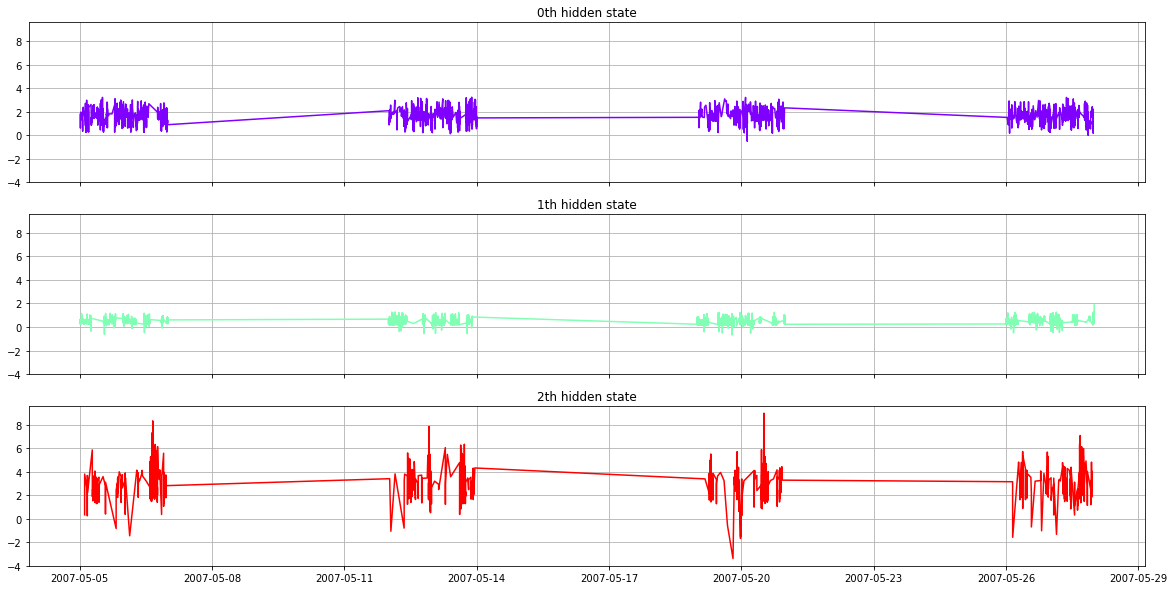

In [35]:
height = 10
width = 20

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True)
fig.set_size_inches(width, height)
colours = cm.rainbow(np.linspace(0, 1, model.n_components))
for i, (ax, colour) in enumerate(zip(axs, colours)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(test_dates[mask], test_features[mask], 'r-', c=colour)
    ax.set_title("{0}th hidden state".format(i))

    # Format the ticks.
#     ax.xaxis.set_major_locator(AutoDateLocator())
    ax.xaxis.set_minor_locator(AutoDateLocator())
    ax.grid(True)
plt.show()